In [1]:
!pip install fastapi uvicorn kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 451.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 499.7 kB/s eta 0:00:00 0:00:01
  Using cached kafka_python-2.0.2-py2.py3-none-any.whl (246 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 647.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 541.5 kB/s eta 0:00:00 0:00:01


In [13]:
from fastapi import FastAPI
from kafka import KafkaProducer
import json
import os
import logging
import time
import cProfile
import uvicorn
import asyncio


logger = logging.getLogger(__name__)  # the __name__ resolve to "uicheckapp.services"

# this is a hack to multiply the work-load inserted into Kafka
names_to_multiply = os.environ.get('NAMES_TO_MULTIPLY', '').split(",")

_producer = None
try:
    _producer = KafkaProducer(bootstrap_servers=os.environ.get('KAFKA_BROKER', 'broker1:9093').split(","), 
                              api_version=(0, 10),
                              max_block_ms=10000)
except Exception as ex:
    logger.error('Exception while connecting Kafka')
    logger.error(str(ex))

time_measurements = []
num_runs = 300 # this is 5 minutes worth of data
run = [0] # hack, to modify inside another scope

app = FastAPI()


@app.get("/")
async def root():
    print("mega sus")
    return {"message": "Hello World"}


# insert URL into SensorLogger app: http://100.102.3.111:8080/data?device=Pixel6&person=Florin&activity=running
# https://github.com/tszheichoi/awesome-sensor-logger/#live-data-streaming
@app.post("/data")
async def data(data: dict, activity: str = None, device: str = None, person: str = None):
    if run[0] >= num_runs:
        print("Enough runs, stop the server")
    count = 0
    start = time.time()
    try:
        for measurement in data["payload"]:
            timestamp_ms = int(measurement["time"]) // 1_000_000 # convert nanoseconds to milliseconds
            value_bytes = bytes(json.dumps(measurement["values"]), encoding='utf-8')
            for name in names_to_multiply + [person]:
                count += 1
                key_bytes = bytes(f"{name}:{device}:{activity}", encoding='utf-8')
                _producer.send(measurement['name'],
                            key=key_bytes,
                            value=value_bytes,
                            timestamp_ms=timestamp_ms) 
        #_producer.flush()
        logger.info('Message published successfully.')
    except Exception as ex:
        logger.error('Exception in publishing message')
        logger.error(str(ex))
    end = time.time()
    time_measurements.append({"count": count, "dur": end-start})
    run[0] += 1
    
    return {"message": "Sensor data received"}

profiler = cProfile.Profile()


if __name__ == "__main__":
    #nest_asyncio.apply()
    #uvicorn.run(app)
    # make available from outside by using the host 0.0.0.0
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    loop = asyncio.get_event_loop()
    loop.create_task(server.serve())

INFO:     Started server process [3179]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK


Task was destroyed but it is pending!
task: <Task pending name='Task-51' coro=<LifespanOn.main() running at /opt/conda/lib/python3.10/site-packages/uvicorn/lifespan/on.py:88> wait_for=<Future pending cb=[Task.task_wakeup()]>>
ERROR:    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/starlette/routing.py", line 686, in lifespan
    await receive()
GeneratorExit



INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&activity=running HTTP/1.1" 200 OK
INFO:     172.18.0.1:55006 - "POST /data?device=Pixel6&person=Florin&acti

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [3179]


In [28]:
len(time_measurements)

283

In [29]:
import numpy as np
import pandas as pd

df = pd.DataFrame(time_measurements[0:num_runs])
df.sample(10)

,count,dur
80,4546,0.209426
69,4542,0.274280
186,4542,0.263728
24,4546,0.208284
149,4540,0.203854
70,4544,0.200377
71,4546,0.298762
177,4546,0.196848
29,4540,0.330870
132,4538,0.269178


In [30]:
df.describe()

,count,dur
count,200.00000,200.000000
mean,4538.51000,0.234169
std,44.98129,0.040679
min,3944.00000,0.187679
25%,4538.00000,0.201613
50%,4542.00000,0.212837
75%,4546.00000,0.269620
max,4660.00000,0.387668


In [31]:
# standardize the duration to the mean of the count
df['dur_standardized'] = df['dur'] * df['count'].mean() / df['count']
desc = df['dur_standardized'].describe()
desc

count    200.000000
mean       0.234246
std        0.041236
min        0.187369
25%        0.201392
50%        0.212533
75%        0.269810
max        0.387200
Name: dur_standardized, dtype: float64

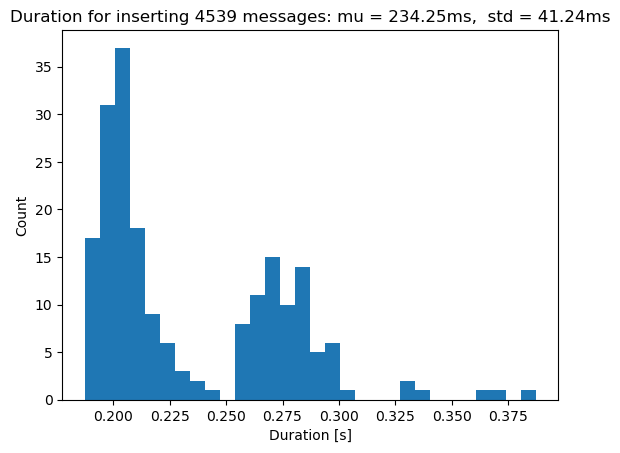

In [40]:
# plot a histogram
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.hist(df['dur_standardized'], bins=30)
plt.ylabel('Count')
plt.xlabel('Duration [s]')
title = f"Duration for inserting {df['count'].mean():.0f} messages: mu = {desc['mean']*1000:.2f}ms,  std = {desc['std']*1000:.2f}ms"
plt.title(title)
plt.show()